In [110]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet

from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns


# Import data

In [3]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
mock_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
mock_df.head()


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_50410/4262528997.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# 1) Mock try

In [5]:
m = Prophet()
m.fit(mock_df)


15:34:52 - cmdstanpy - INFO - Chain [1] start processing
15:34:53 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=365)
future.head()


,ds
0,2007-12-10
1,2007-12-11
2,2007-12-12
3,2007-12-13
4,2007-12-14


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.204239,7.540284,8.932394
3266,2017-01-16,8.529231,7.820480,9.282256
3267,2017-01-17,8.316611,7.709121,9.042063
3268,2017-01-18,8.149244,7.488673,8.889674
3269,2017-01-19,8.161142,7.467721,8.937606


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


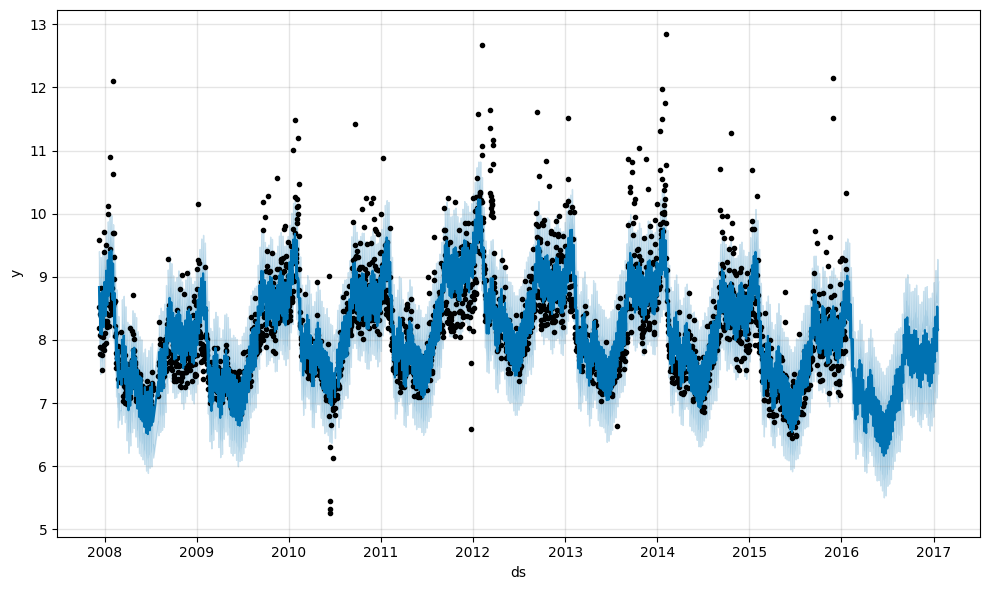

In [11]:
fig1 = m.plot(forecast)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated,

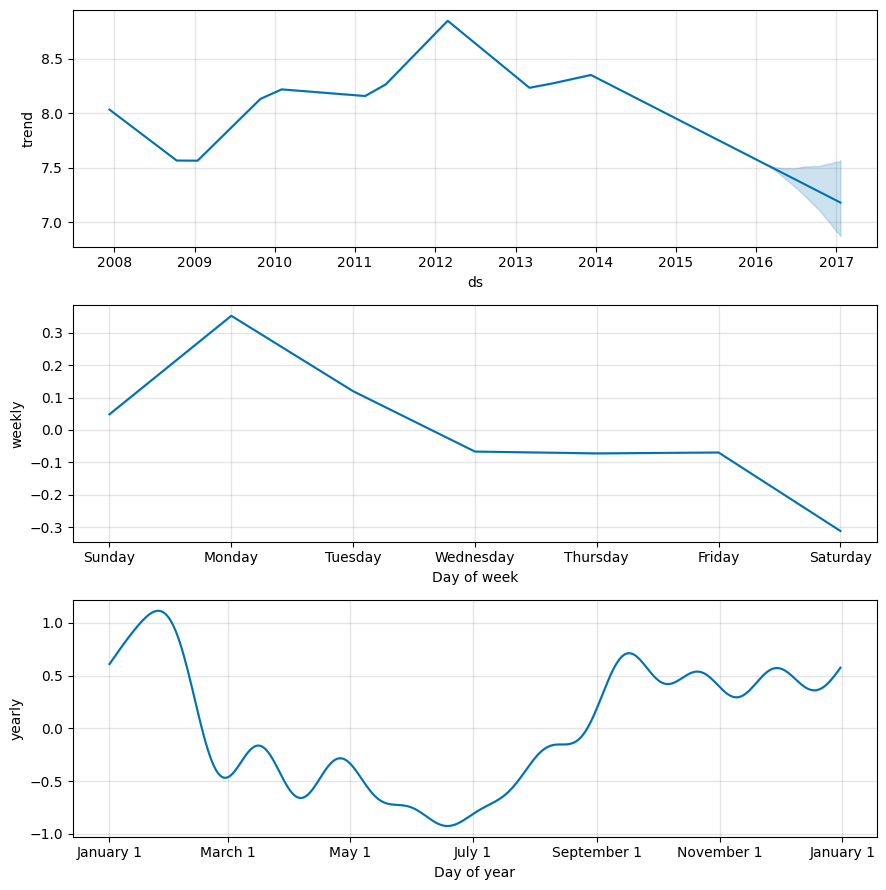

In [12]:
fig2 = m.plot_components(forecast)


In [14]:
plot_plotly(m, forecast)


In [15]:
plot_components_plotly(m, forecast)


# 2) Essai Metro Seoul

## Preprocessing

In [21]:
import sys


In [22]:
print(sys.path)


['/Users/thomas_metral/code/thomas-metral/metro_seoul/notebooks', '/Users/thomas_metral/code/thomas-metral/04-Decision-Science/01-Project-Setup/data-context-and-setup', '/Users/thomas_metral/code/thomas-metral/metro_seoul/notebooks', '/Users/thomas_metral/.pyenv/versions/3.10.6/lib/python310.zip', '/Users/thomas_metral/.pyenv/versions/3.10.6/lib/python3.10', '/Users/thomas_metral/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload', '', '/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages']


In [26]:
sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')


In [30]:
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing


In [28]:
df = general_preprocessing(df)


/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
df = model_data_preprocessing(df)


## Station 156

### preprocess

In [44]:
#Isolating the entries of one station
df_156 = df[df['station_number'] == 156]
df_156 = df_156[df_156['entry/exit'] == 'entry']

#renaming columns for prophet
df_156.rename(columns={'value':'y'}, inplace=True)
df_156.index.names = ['ds']

#sorting dates as ascending
df_156.sort_index(ascending=True, inplace=True)


In [57]:
#split data test train
train_size = 0.9
index = round(train_size*df_156.shape[0])
df_156_train = df_156.iloc[:index]
df_156_test = df_156.iloc[index:]


In [58]:
df_156_train


,line,station_number,station_name,entry/exit,y
ds,,,,,
2020-01-01 01:00:00,1,156,Sinseoldong,entry,0
2020-01-01 02:00:00,1,156,Sinseoldong,entry,0
2020-01-01 03:00:00,1,156,Sinseoldong,entry,0
2020-01-01 04:00:00,1,156,Sinseoldong,entry,0
2020-01-01 05:00:00,1,156,Sinseoldong,entry,164
...,...,...,...,...,...
2023-03-01 03:00:00,1,156,Sinseoldong,entry,0
2023-03-01 04:00:00,1,156,Sinseoldong,entry,0
2023-03-01 05:00:00,1,156,Sinseoldong,entry,203


### Cross Validation


In [95]:
#trying with a smaller dataset
df_156_short = df_156.iloc[-12000:]
df_156_short


,line,station_number,station_name,entry/exit,y
ds,,,,,
2021-12-18 01:00:00,1,156,Sinseoldong,entry,0
2021-12-18 02:00:00,1,156,Sinseoldong,entry,0
2021-12-18 03:00:00,1,156,Sinseoldong,entry,0
2021-12-18 04:00:00,1,156,Sinseoldong,entry,0
2021-12-18 05:00:00,1,156,Sinseoldong,entry,208
...,...,...,...,...,...
2023-06-30 20:00:00,1,156,Sinseoldong,entry,631
2023-06-30 21:00:00,1,156,Sinseoldong,entry,484
2023-06-30 22:00:00,1,156,Sinseoldong,entry,345


In [112]:
m_test = Prophet()
m_test.fit(df_156_short.reset_index())

df_cv = cross_validation(m_test, initial='499 days', period='100 days', horizon = '2 days')


17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/1 [00:00<?, ?it/s]17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [113]:
df_cv[['ds','yhat','y']].head(20)


,ds,yhat,y
0,2023-06-29 01:00:00,165.068528,0
1,2023-06-29 02:00:00,69.666984,0
2,2023-06-29 03:00:00,34.572340,0
3,2023-06-29 04:00:00,134.586629,0
4,2023-06-29 05:00:00,350.579888,348
5,2023-06-29 06:00:00,584.556388,358
6,2023-06-29 07:00:00,741.091206,950
7,2023-06-29 08:00:00,794.930320,1282
8,2023-06-29 09:00:00,787.253837,742
9,2023-06-29 10:00:00,768.504794,593


<Axes: xlabel='ds', ylabel='yhat'>

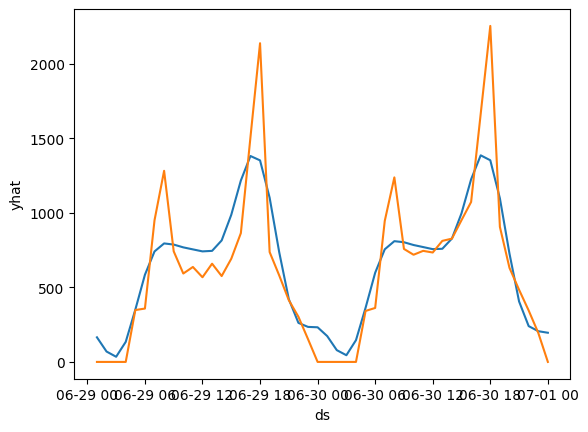

In [115]:
sns.lineplot(x=df_cv['ds'], y=df_cv['yhat'])
sns.lineplot(x=df_cv['ds'], y=df_cv['y'])


#### Performance metrics

In [103]:
df_p = performance_metrics(df_cv)
df_p.head(10)


,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days 00:00:00,71408.724836,267.224110,178.037436,0.252577,0.606466,0.916667
1,1 days 01:00:00,71768.230411,267.895932,179.234962,0.252577,0.606466,0.916667
2,1 days 02:00:00,71897.740048,268.137539,180.403059,0.252577,0.606466,0.916667
3,1 days 03:00:00,71945.377095,268.226354,181.531266,0.252577,0.606466,0.916667
4,1 days 04:00:00,72207.587723,268.714696,182.610366,0.252577,0.606466,0.916667
5,1 days 05:00:00,72223.845456,268.744945,182.825791,0.252577,0.606247,0.916667
6,1 days 06:00:00,71783.910705,267.925196,181.784660,0.252577,0.602564,0.916667
7,1 days 07:00:00,71340.064574,267.095609,180.727176,0.252577,0.601185,0.916667
8,1 days 08:00:00,67794.036776,260.372880,177.407548,0.252577,0.598430,0.916667
9,1 days 09:00:00,67848.841418,260.478102,178.405324,0.252577,0.599743,0.916667


TypeError: 'NoneType' object is not subscriptable

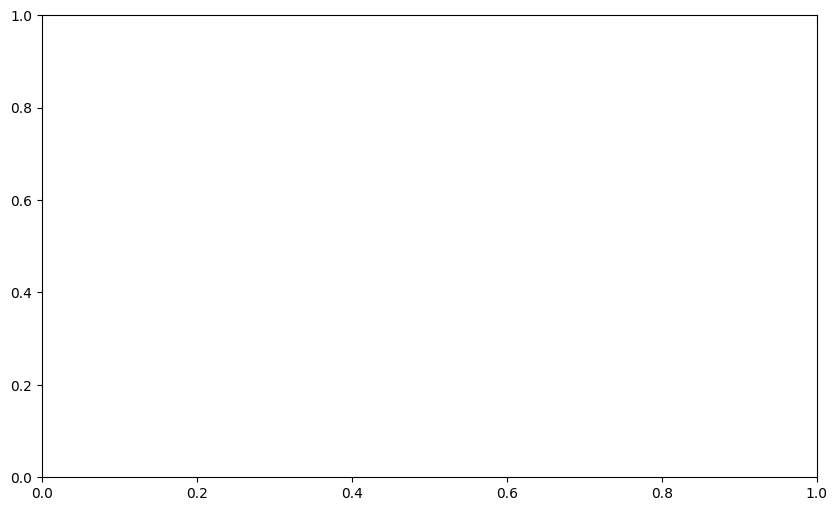

In [105]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


### Fit

In [59]:
#resetting index to have a ds column (mandatory)
m = Prophet()
m.fit(df_156_train.reset_index())


16:39:47 - cmdstanpy - INFO - Chain [1] start processing
16:39:50 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future = m.make_future_dataframe(periods=200, freq='h', include_history=False)
future


,ds
0,2023-03-01 08:00:00
1,2023-03-01 09:00:00
2,2023-03-01 10:00:00
3,2023-03-01 11:00:00
4,2023-03-01 12:00:00
...,...
195,2023-03-09 11:00:00
196,2023-03-09 12:00:00
197,2023-03-09 13:00:00
198,2023-03-09 14:00:00


In [86]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10)


,ds,yhat,yhat_lower,yhat_upper
0,2023-03-01 08:00:00,678.395842,363.313038,991.673136
1,2023-03-01 09:00:00,674.558834,346.003201,1022.164205
2,2023-03-01 10:00:00,678.532047,360.479721,1014.713289
3,2023-03-01 11:00:00,686.512131,375.581446,1035.071857
4,2023-03-01 12:00:00,676.249890,328.558356,1019.150298
5,2023-03-01 13:00:00,665.308302,354.041565,997.835914
6,2023-03-01 14:00:00,721.542571,382.617165,1033.079285
7,2023-03-01 15:00:00,899.154310,561.266775,1216.337210
8,2023-03-01 16:00:00,1158.794016,830.489243,1487.004448
9,2023-03-01 17:00:00,1360.438388,1074.466161,1706.554460


In [87]:
df_156_test['y'].head(10)


ds
2023-03-01 08:00:00    324
2023-03-01 09:00:00    433
2023-03-01 10:00:00    477
2023-03-01 11:00:00    604
2023-03-01 12:00:00    667
2023-03-01 13:00:00    694
2023-03-01 14:00:00    717
2023-03-01 15:00:00    704
2023-03-01 16:00:00    822
2023-03-01 17:00:00    672
Name: y, dtype: int64

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



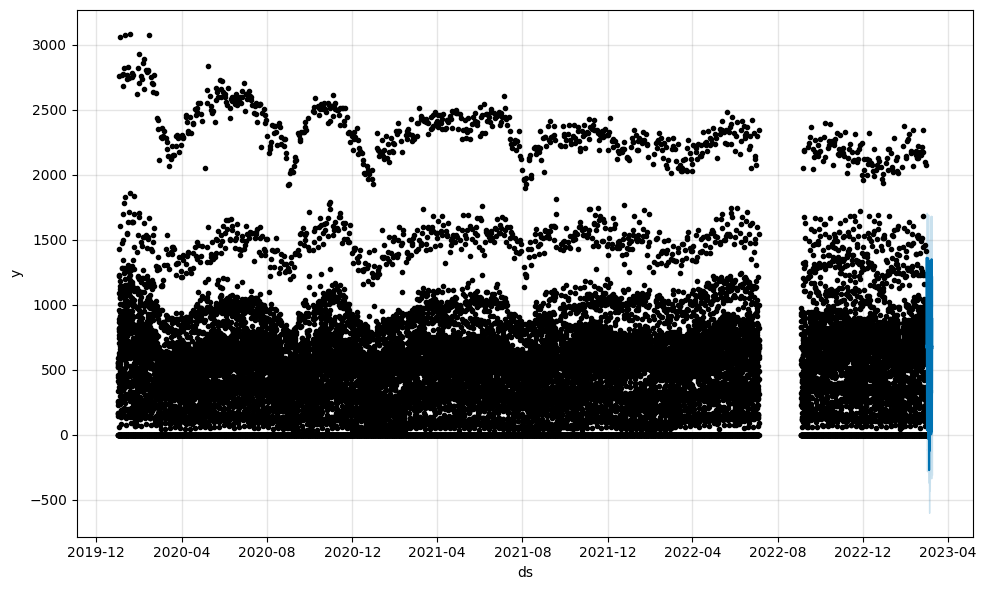

In [88]:
fig1 = m.plot(forecast)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

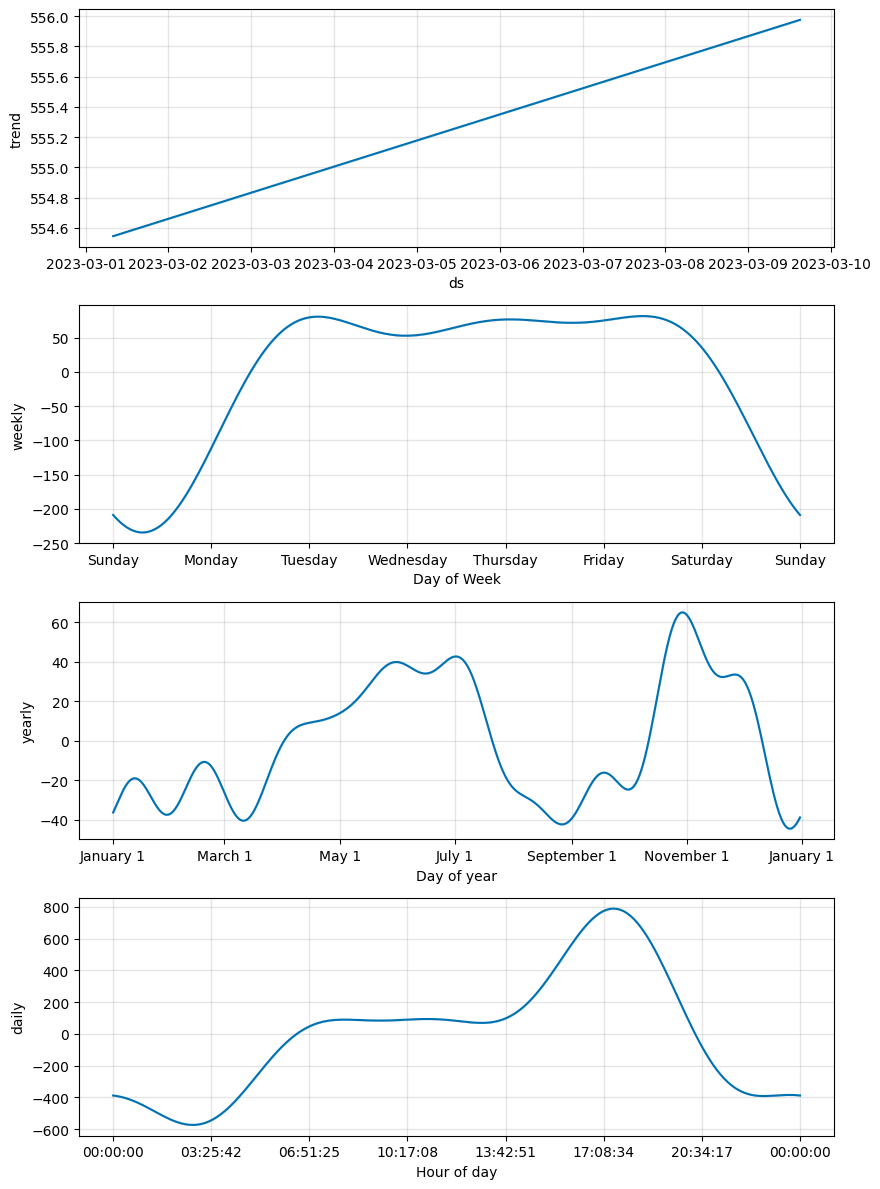

In [89]:
fig2 = m.plot_components(forecast)


In [90]:
plot_plotly(m, forecast)


In [91]:
plot_components_plotly(m, forecast)
